# Implementing DCGAN on SVHN

Data taken from a previous [GAN project based](https://github.com/NGrech/generate-faces/blob/main/dlnd_face_generation.ipynb) and was based on a tutorial by [Udacity](https://github.com/udacity/deep-learning-v2-pytorch/blob/master/dcgan-svhn/DCGAN_Exercise.ipynb) 

## Imports

In [29]:
import torch
import os
import torchvision
import torch.optim as optim
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torchvision.transforms import ToTensor, Lambda, Grayscale, Compose, Resize
from torchvision import transforms, datasets
from torchvision.datasets import FashionMNIST, ImageFolder
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import torchvision.utils as vutils
import numpy as np
import pickle as pkl

import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
device

device(type='cuda')

## Hyperparameters 

In [30]:
latent_dimension = 100
batch_size = 128
num_workers = 0
beta1 = 0.5
lr = 0.0002
num_epochs = 15

## Loading Street View House Numbers (SVHN) dataset

Data taken from a previous [GAN project based](https://github.com/NGrech/generate-faces/blob/main/dlnd_face_generation.ipynb) and was based on a tutorial by [Udacity](https://github.com/udacity/deep-learning-v2-pytorch/blob/master/dcgan-svhn/DCGAN_Exercise.ipynb) 

In [31]:
transform = transforms.Compose([
        transforms.ToTensor()
    ])    

svhn_train = datasets.SVHN(root='../data', split='train', download=True, transform=transform)
svhn_test = datasets.SVHN(root='../data', split='test', download=True, transform=transform)


train_loader = torch.utils.data.DataLoader(dataset=svhn_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(dataset=svhn_test,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=num_workers)

Using downloaded and verified file: ../data\train_32x32.mat
Using downloaded and verified file: ../data\test_32x32.mat


## Helpers 

In [32]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Define Discriminator 

In [33]:
class SVHN_Discriminator(nn.Module):

    def __init__(self):
        super(SVHN_Discriminator, self).__init__()
        self.conv_dims = 32

        self.conv1 = nn.Conv2d(3, self.conv_dims, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Sequential(
            nn.Conv2d(self.conv_dims, self.conv_dims*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(self.conv_dims*2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(self.conv_dims*2, self.conv_dims*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(self.conv_dims*4)
        )

        self.fc = nn.Linear(self.conv_dims*4*4*4, 1)


    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = out.view(-1, self.conv_dims*4*4*4)
        return torch.sigmoid(self.fc(out))

D = SVHN_Discriminator().to(device)
D

SVHN_Discriminator(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

## Define Generator 

In [34]:
class SVHN_Generator(nn.Module):
    
    def __init__(self, z_size):
        super(SVHN_Generator, self).__init__()
        self.conv_dims = 32

        self.fc = nn.Linear(z_size, self.conv_dims*4*4*4)
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(self.conv_dims*4, self.conv_dims*2,  kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(self.conv_dims*2)
        )
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(self.conv_dims*2, self.conv_dims,  kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(self.conv_dims)
        )
        self.deconv3 = nn.ConvTranspose2d(self.conv_dims, 3,  kernel_size=4, stride=2, padding=1)

    def forward(self, z):
        out = self.fc(z)
        out = out.view(-1, self.conv_dims*4, 4, 4)
        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))
        return torch.tanh(self.deconv3(out))

G = SVHN_Generator(z_size=100).to(device)
G

SVHN_Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv3): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

## Initializing weights

In [35]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

#G.apply(weights_init)
#D.apply(weights_init)

## Training Setup 

In [36]:
# Initialize Binary Cross Entropy Loss
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, 100))
fixed_z = torch.from_numpy(fixed_z).float().to(device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))

## Training 

In [37]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
print_every = 300

## For Testing 
num_epochs = 50

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (real_images, _) in enumerate(train_loader, 0):

        # (1) Updating the D net:
        D.zero_grad()
        
        # Format batch
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        # Forward pass with real images
        D_real = D(real_images)
        labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)


        errD_real = criterion(D_real.squeeze(), labels)

        # Backward pass
        errD_real.backward(retain_graph=True)

        # Forward pass w/ fakes
        # Make some noise 
        noise = torch.randn(batch_size, latent_dimension, device=device)

        # Generate with G
        fake = G(noise)

        # Classify w/ D
        D_fake = D(fake)
        labels.fill_(fake_label)

        # Get fake error
        errD_fake = criterion(D_fake.squeeze(), labels)
        
        # Backward pass
        errD_fake.backward(retain_graph=True)
        
        # Compute D error 
        errD = errD_real + errD_fake
        optimizerD.step()

        # (2) Update G network

        G.zero_grad()

        D_gen = D(fake)
        labels.fill_(real_label)

        # Get fake error
        errG_fake = criterion(D_gen.squeeze(), labels)
        errG_fake.backward(retain_graph=True)
        optimizerG.step()


         # Output training stats
        if i % print_every == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     errD.item(), errG_fake.item()))

        # Save Losses for plotting later
        G_losses.append(errG_fake.item())
        D_losses.append(errD.item())

    G.eval() # for generating samples
    samples_z = G(fixed_z)
    img_list.append(samples_z)
    G.train() # back to training mode


Starting Training Loop...
[0/50][0/573]	Loss_D: 1.3644	Loss_G: 0.8486
[0/50][300/573]	Loss_D: 0.4918	Loss_G: 1.1549
[1/50][0/573]	Loss_D: 0.4821	Loss_G: 1.1389
[1/50][300/573]	Loss_D: 0.4759	Loss_G: 1.1313
[2/50][0/573]	Loss_D: 0.4723	Loss_G: 1.1225
[2/50][300/573]	Loss_D: 0.4749	Loss_G: 1.1059
[3/50][0/573]	Loss_D: 0.4684	Loss_G: 1.1070
[3/50][300/573]	Loss_D: 0.4647	Loss_G: 1.1008
[4/50][0/573]	Loss_D: 0.4696	Loss_G: 1.0897
[4/50][300/573]	Loss_D: 0.4665	Loss_G: 1.0884
[5/50][0/573]	Loss_D: 0.4705	Loss_G: 1.0780
[5/50][300/573]	Loss_D: 0.4626	Loss_G: 1.0880
[6/50][0/573]	Loss_D: 0.4637	Loss_G: 1.0828
[6/50][300/573]	Loss_D: 0.4595	Loss_G: 1.0876
[7/50][0/573]	Loss_D: 0.4634	Loss_G: 1.0770
[7/50][300/573]	Loss_D: 0.4648	Loss_G: 1.0738
[8/50][0/573]	Loss_D: 0.4606	Loss_G: 1.0786
[8/50][300/573]	Loss_D: 0.4634	Loss_G: 1.0714
[9/50][0/573]	Loss_D: 0.4640	Loss_G: 1.0687
[9/50][300/573]	Loss_D: 0.4603	Loss_G: 1.0735
[10/50][0/573]	Loss_D: 0.4618	Loss_G: 1.0668
[10/50][300/573]	Loss_D: 0.45

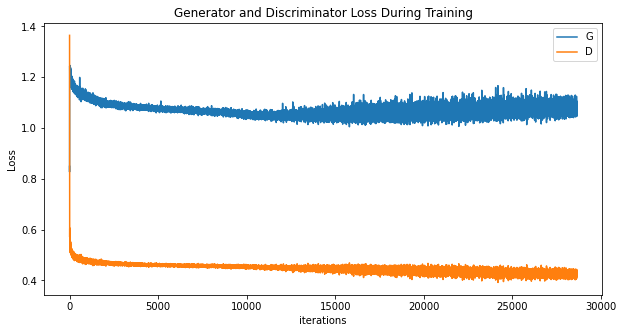

In [38]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [39]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        #img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))


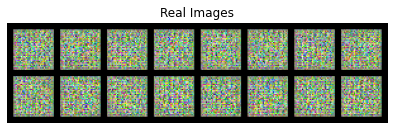

In [40]:
with torch.no_grad():
    fake = G(fixed_z).detach().cpu()
    
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(fake, padding=5, normalize=True).cpu(),(1,2,0)))

In [41]:
import plotly.express as px

i = img_list[-1][0].detach().cpu().numpy()


i.shape

(3, 32, 32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

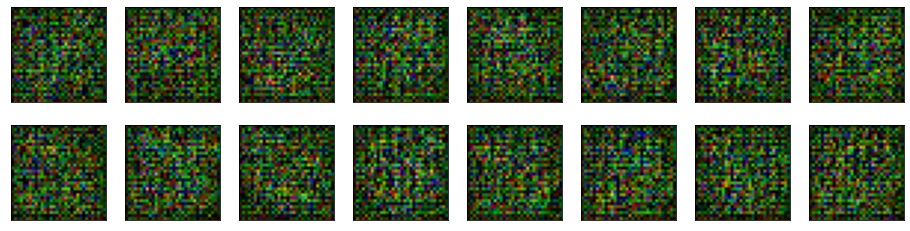

In [42]:
_ = view_samples(-1, img_list)